# Analysis of Kallikrein-6 protein concentration in patients with Alzheimer's disease and controls

Important notes: Add here



In [ ]:
#important libraries to load
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats # for stats.probplot, check QQ plot for normally distributed data
import seaborn as sns
from scipy.stats import f_oneway # one-way ANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tabulate import tabulate #pretty table
from dateutil.relativedelta import relativedelta #use this to accurately account for month and day differences when calculating age

In [85]:
#Read files based on location (SHOULD BE CHANGED BY USER)

file_path = "C:\\Users\\miyoh\\Git_Hub_Work\\Python_data_analysis\\KLK6_ELISA_data_correct_for_dilution.xlsx" #Edit accordingly to where the file is
file_path2= "C:\\Users\\miyoh\\Git_Hub_Work\\Python_data_analysis\\20240321_400CSF_selection_for_Toronto_reduced_FC_Corrected.xlsx" #clinical information of patients from collaborator
data= pd.read_excel(file_path, "Sheet2")
clinical_info = pd.read_excel(file_path2, "Sheet 1")

## Preliminary checks

### Prepare df (not clinical information dataframe)

In [86]:
data #check that it was read fine

#it has 394 rows and 4 columns, but we should have 393 samples.

,Combination of dates and plates,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Value,ID,Group,Original_ID_ACE
1,316.5,AD1,MCI_nonProgressor,CC000045.05
2,193.5,AD2,MCI_conver_toDem,CC000062.05
3,298,AD3,MCI_nonProgressor,CC000020.05
4,415,AD4,MCI_conver_toDem,CC000009.05
...,...,...,...,...
389,251.5,AD389,SCD,CC000142.08
390,264,AD390,SCD,CC000143.08
391,173.5,AD391,SCD,CC000238.07
392,256,AD392,SCD,CC000257.08


In [88]:
#the columns from df need to be renamed

data.columns = data.iloc[0] #the new column names are taken from row 1
data = data.drop(data.index[0]) #drop the first row, since we have now saved is as column names

In [89]:
data #check that it worked, new column names should be Value, ID, Group, Original_ID_ACE

,Value,ID,Group,Original_ID_ACE
1,316.5,AD1,MCI_nonProgressor,CC000045.05
2,193.5,AD2,MCI_conver_toDem,CC000062.05
3,298,AD3,MCI_nonProgressor,CC000020.05
4,415,AD4,MCI_conver_toDem,CC000009.05
5,386,AD5,MCI_conver_toDem,CC000026.05
...,...,...,...,...
389,251.5,AD389,SCD,CC000142.08
390,264,AD390,SCD,CC000143.08
391,173.5,AD391,SCD,CC000238.07
392,256,AD392,SCD,CC000257.08


In [114]:
#get info on data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 1 to 393
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               393 non-null    object 
 1   Group            393 non-null    object 
 2   Value            393 non-null    float64
 3   Original_ID_ACE  393 non-null    object 
dtypes: float64(1), object(3)
memory usage: 12.4+ KB


In [90]:
#make Value column a numeric value

#In order to do QQ-plots later, I have to turn the Value column into a float (rather than have it as object)
#this way, the other two columns remain intact, without being removed

data = data[["ID", "Group", "Value", "Original_ID_ACE"]].apply(pd.to_numeric, errors = "ignore")

C:\Users\miyoh\AppData\Local\Temp\ipykernel_7476\2530286641.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data[["ID", "Group", "Value", "Original_ID_ACE"]].apply(pd.to_numeric, errors = "ignore")


### Prepare clinical information

In [93]:
clinical_info #correctly has 393 samples

,CORRECTION,Group,Codigo_ACE_LCR,Interno,Sexo,F.Nacimiento,APOE,FechaLCR,Abeta_42_LCR,P_tau_LCR,...,P2,POS,Aliq,Alteraciones.muestra,Ubi,Congelador,Estado,Observaciones,where,nAliq
0,NaN,AD,C0000007,20161241,Masculino,1933-09-23,e3e3,2016-11-30,468.0,119.0,...,9,G9,CC000007.04,NaN,BIOMAT,NaN,NaN,NaN,bb_Biomat,9
1,NaN,AD,C0000039,20150639,Masculino,1942-10-12,e3e4,2017-02-22,612.0,110.0,...,3,C3,CC000039.03,NaN,BIOMAT,NaN,NaN,NaN,bb_Biomat,7
2,NaN,AD,C0000117,20170452,Masculino,1948-03-05,e3e3,2017-06-12,581.0,82.0,...,1,I1,CC000117.04,NaN,BIOMAT,NaN,NaN,NaN,bb_Biomat,9
3,NaN,AD,C0000149,20170818,Masculino,1942-11-06,e3e4,2017-07-10,663.0,86.0,...,1,A1,CC000149.04,NaN,BIOMAT,NaN,NaN,NaN,bb_Biomat,10
4,NaN,AD,C0000150,20161423,Masculino,1941-01-10,e3e4,2017-07-10,559.0,90.0,...,9,B9,CC000150.04,NaN,BIOMAT,NaN,NaN,NaN,bb_Biomat,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,NaN,SCD,C0001404,20171072,Femenino,1964-07-13,e3e3,2021-07-06,1589.0,58.0,...,9,C9,CC001404.04,NaN,BIOMAT,NaN,NaN,NaN,bb_Biomat,12
389,CDR corrected,SCD,C0001426,20141202,Femenino,1962-12-03,e3e3,2021-10-05,731.0,19.0,...,5,D5,CC001426.04,NaN,BIOMAT,NaN,NaN,NaN,bb_Biomat,14
390,NaN,SCD,C0002281,20220644,Femenino,1959-12-11,NaN,2023-09-19,655.0,23.0,...,8,F8,CC002281.04,NaN,BIOMAT,NaN,NaN,NaN,bb_Biomat,13
391,NaN,SCD,C0002335,20230393,Femenino,1956-04-12,NaN,2023-10-27,814.0,23.0,...,4,F4,CC002335.04,NaN,BIOMAT,NaN,NaN,NaN,bb_Biomat,14


In [94]:
#Access column names, so that a selection can be made
clinical_info.columns

Index(['CORRECTION', 'Group', 'Codigo_ACE_LCR', 'Interno', 'Sexo',
       'F.Nacimiento', 'APOE', 'FechaLCR', 'Abeta_42_LCR', 'P_tau_LCR',
       'T_tau_LCR', 'Ratio_Abeta42_40_LCR', 'Tecnica_Empleada_LCR',
       'A_1pos_0neg', 'T_1pos_0neg', 'N_1pos_0neg', 'ATN', 'FechaSeguiment_PL',
       'Diagnostic_Primari_PL_Etiqueta', 'Diagnostic_Secundari_PL_Etiqueta',
       'Diagnostic_Sindromic_PL_Etiqueta', 'CDR_PL', 'GDS_PL', 'MMSE_PL',
       'protocol_MCI', 'followup_1y_0n', 'MCI_dementia_conversion_1y_0n',
       'MCI_conversion_1AD_0DementiaNoAD', 'Years_FollowUp',
       'Date_Conversion_LastFollowup',
       'Diagnostic_Primari_Conversion_Etiqueta',
       'Diagnostic_Secundari_Conversion_Etiqueta',
       'Diagnostic_Sindromic_Conversion_Etiqueta', 'CDR_Conversion',
       'GDS_Conversion', 'MMSE_conversion', 'CAJA', 'P1', 'P2', 'POS', 'Aliq',
       'Alteraciones.muestra', 'Ubi', 'Congelador', 'Estado', 'Observaciones',
       'where', 'nAliq'],
      dtype='object')

In [95]:
# Create another dataframe with picked columns

clinical_info_chosen = clinical_info[["Aliq", "MMSE_PL", "APOE", "Sexo",
                                      "F.Nacimiento", "FechaLCR"]]

In [96]:
#check clinical_info_chosen

clinical_info_chosen

,Aliq,MMSE_PL,APOE,Sexo,F.Nacimiento,FechaLCR
0,CC000007.04,26.0,e3e3,Masculino,1933-09-23,2016-11-30
1,CC000039.03,22.0,e3e4,Masculino,1942-10-12,2017-02-22
2,CC000117.04,17.0,e3e3,Masculino,1948-03-05,2017-06-12
3,CC000149.04,24.0,e3e4,Masculino,1942-11-06,2017-07-10
4,CC000150.04,17.0,e3e4,Masculino,1941-01-10,2017-07-10
...,...,...,...,...,...,...
388,CC001404.04,29.0,e3e3,Femenino,1964-07-13,2021-07-06
389,CC001426.04,29.0,e3e3,Femenino,1962-12-03,2021-10-05
390,CC002281.04,28.0,NaN,Femenino,1959-12-11,2023-09-19
391,CC002335.04,30.0,NaN,Femenino,1956-04-12,2023-10-27


In [115]:
#get info on data types and missing values
clinical_info_chosen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Aliq          393 non-null    object        
 1   MMSE_PL       375 non-null    float64       
 2   APOE          382 non-null    object        
 3   Sexo          393 non-null    object        
 4   F.Nacimiento  393 non-null    datetime64[ns]
 5   FechaLCR      393 non-null    datetime64[ns]
 6   Age           393 non-null    int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 21.6+ KB


In [98]:
#turn F.Nacimiento into datetime()

clinical_info_chosen["F.Nacimiento"] = pd.to_datetime(clinical_info_chosen["F.Nacimiento"])

C:\Users\miyoh\AppData\Local\Temp\ipykernel_7476\2128082406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_info_chosen["F.Nacimiento"] = pd.to_datetime(clinical_info_chosen["F.Nacimiento"])


In [99]:
#Create a new column for Age = FechaLCR- F.Nacimiento

clinical_info_chosen['Age'] = [relativedelta(i,j).years for i,j in zip(clinical_info_chosen["FechaLCR"], clinical_info_chosen["F.Nacimiento"])]

C:\Users\miyoh\AppData\Local\Temp\ipykernel_7476\1538170656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_info_chosen['Age'] = [relativedelta(i,j).years for i,j in zip(clinical_info_chosen["FechaLCR"], clinical_info_chosen["F.Nacimiento"])]


In [100]:
#Rename Masculino = Male, Femenino = Female

clinical_info_chosen["Sexo"] = clinical_info_chosen["Sexo"].replace("Masculino", "Male")
clinical_info_chosen["Sexo"] = clinical_info_chosen["Sexo"].replace("Femenino", "Female")


C:\Users\miyoh\AppData\Local\Temp\ipykernel_7476\3094514504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_info_chosen["Sexo"] = clinical_info_chosen["Sexo"].replace("Masculino", "Male")
C:\Users\miyoh\AppData\Local\Temp\ipykernel_7476\3094514504.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_info_chosen["Sexo"] = clinical_info_chosen["Sexo"].replace("Femenino", "Female")


In [101]:
#check results
clinical_info_chosen

,Aliq,MMSE_PL,APOE,Sexo,F.Nacimiento,FechaLCR,Age
0,CC000007.04,26.0,e3e3,Male,1933-09-23,2016-11-30,83
1,CC000039.03,22.0,e3e4,Male,1942-10-12,2017-02-22,74
2,CC000117.04,17.0,e3e3,Male,1948-03-05,2017-06-12,69
3,CC000149.04,24.0,e3e4,Male,1942-11-06,2017-07-10,74
4,CC000150.04,17.0,e3e4,Male,1941-01-10,2017-07-10,76
...,...,...,...,...,...,...,...
388,CC001404.04,29.0,e3e3,Female,1964-07-13,2021-07-06,56
389,CC001426.04,29.0,e3e3,Female,1962-12-03,2021-10-05,58
390,CC002281.04,28.0,NaN,Female,1959-12-11,2023-09-19,63
391,CC002335.04,30.0,NaN,Female,1956-04-12,2023-10-27,67


### Combine df with clinical_info_chosen

In [103]:
#Merge the dataframes with different column names for merging

df = pd.merge(data, clinical_info_chosen, left_on= "Original_ID_ACE", right_on= "Aliq", how= "left")
print("\nMerged DataFrame (Left Join with different column names):")
print(df)


Merged DataFrame (Left Join with different column names):
        ID              Group  Value Original_ID_ACE         Aliq  MMSE_PL  \
0      AD1  MCI_nonProgressor  316.5     CC000045.05  CC000045.05     28.0   
1      AD2   MCI_conver_toDem  193.5     CC000062.05  CC000062.05     19.0   
2      AD3  MCI_nonProgressor  298.0     CC000020.05  CC000020.05     29.0   
3      AD4   MCI_conver_toDem  415.0     CC000009.05  CC000009.05     27.0   
4      AD5   MCI_conver_toDem  386.0     CC000026.05  CC000026.05     22.0   
..     ...                ...    ...             ...          ...      ...   
388  AD389                SCD  251.5     CC000142.08  CC000142.08     30.0   
389  AD390                SCD  264.0     CC000143.08  CC000143.08     30.0   
390  AD391                SCD  173.5     CC000238.07  CC000238.07      NaN   
391  AD392                SCD  256.0     CC000257.08  CC000257.08     29.0   
392  AD393                SCD  260.0     CC000846.04  CC000846.04     29.0   

    

## Check normality

To see if the data are normally distributed, it is possible to run two statistical tests:
- Shapiro-Wilk Test, which is suitable for smaller sample sizes (typically <50), where the null hypothesis is that the data are normally distributed.
- D'Agostino's K-squared test (normaltest), which is based on skewness and kurtosis and is generally suitable for larger sample sizes. Similar to Shapiro-Wilk, a low p-value suggests non-normalilty.

In [104]:
#perform D"Agostino K^2 test

groups = df['Group'].unique() #group by Group

for group_name in groups:
    group_data = df[df["Group"] == group_name]["Value"]
    statistic, p_value = stats.normaltest(group_data) #if we wanted to do Shapiro-Wilk, we would run a shapiro()
    print(f"Normality test for Group {group_name}:")
    print(f" D'Agostino K^2 Statistic: {statistic:.4f}")
    print(f" P-value: {p_value:.4f}")

    alpha = 0.05 #significance level
    if p_value > alpha:
        print(f"Result: Data for Group {group_name} appears to be normally distributed (fail to reject H0)")
    else:
        print(f"Result: Data for group {group_name} does not appear to be normally distributed (reject H0)")
    print("-" * 30)

Normality test for Group MCI_nonProgressor:
 D'Agostino K^2 Statistic: 14.1508
 P-value: 0.0008
Result: Data for group MCI_nonProgressor does not appear to be normally distributed (reject H0)
------------------------------
Normality test for Group MCI_conver_toDem:
 D'Agostino K^2 Statistic: 28.8070
 P-value: 0.0000
Result: Data for group MCI_conver_toDem does not appear to be normally distributed (reject H0)
------------------------------
Normality test for Group SCD:
 D'Agostino K^2 Statistic: 8.6447
 P-value: 0.0133
Result: Data for group SCD does not appear to be normally distributed (reject H0)
------------------------------
Normality test for Group AD:
 D'Agostino K^2 Statistic: 58.2569
 P-value: 0.0000
Result: Data for group AD does not appear to be normally distributed (reject H0)
------------------------------


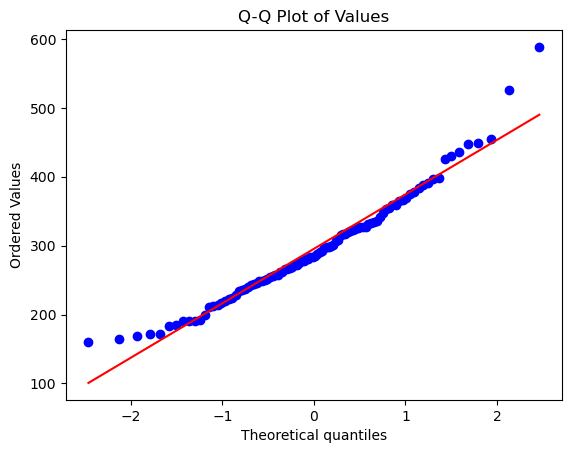

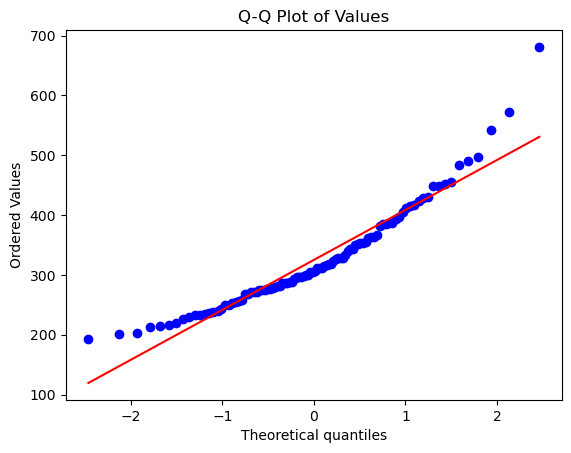

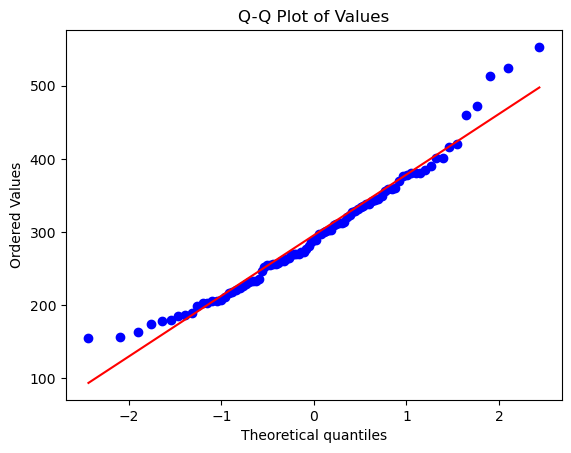

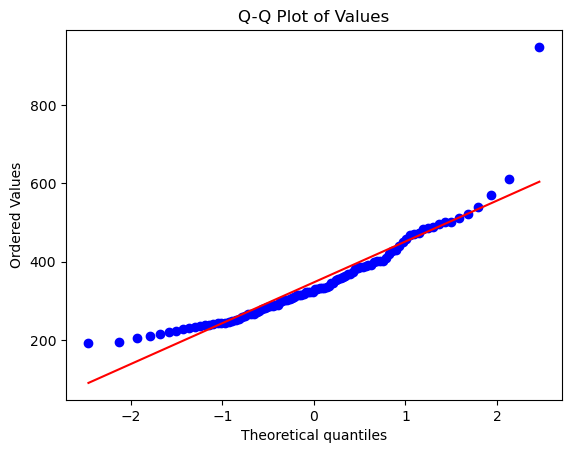

In [105]:
#alternatively, check normal distribution using QQ plot

for group_name in groups:
    group_data = df[df["Group"] == group_name]["Value"]
    stats.probplot(group_data,dist = "norm", plot=plt)
    plt.title("Q-Q Plot of Values")
    plt.show()

In [106]:
#Since our data is not normally distributed, we log2 transform our values
#in a new column, which will be used from now on

df["log2_Value"] = np.log2(df["Value"])

In [107]:
#Check for normality again using the log2 values

for group_name in groups:
    group_data = df[df["Group"] == group_name]["log2_Value"]
    statistic, p_value = stats.normaltest(group_data)
    print(f"Normality test for Group {group_name}:")
    print(f" Shapiro-Wilk Statistic: {statistic:.4f}")
    print(f" P-value: {p_value:.4f}")

    alpha = 0.05 #significance level
    if p_value > alpha:
        print(f"Result: Data for Group {group_name} appears to be normally distributed (fail to reject H0)")
    else:
        print(f"Result: Data for group {group_name} does not appear to be normally distributed (reject H0)")
    print("-" * 30)

Normality test for Group MCI_nonProgressor:
 Shapiro-Wilk Statistic: 0.0006
 P-value: 0.9997
Result: Data for Group MCI_nonProgressor appears to be normally distributed (fail to reject H0)
------------------------------
Normality test for Group MCI_conver_toDem:
 Shapiro-Wilk Statistic: 4.0030
 P-value: 0.1351
Result: Data for Group MCI_conver_toDem appears to be normally distributed (fail to reject H0)
------------------------------
Normality test for Group SCD:
 Shapiro-Wilk Statistic: 0.3784
 P-value: 0.8276
Result: Data for Group SCD appears to be normally distributed (fail to reject H0)
------------------------------
Normality test for Group AD:
 Shapiro-Wilk Statistic: 5.9537
 P-value: 0.0510
Result: Data for Group AD appears to be normally distributed (fail to reject H0)
------------------------------


Prior to ANOVA, we have to check for variances, since they have to be equal

(we have to assume that the variability within each group being compared is roughly the sampe)

To do this, we can do the Bartlett's test, or Levene's test. We have used Levene's test which checks for homogeneity of variances but is less sensitive to departures from normality than Bartlett's test, making it more robust.

In [108]:
#Create 4 groups for stat analysis based on Group column
group_nonprog = df[df["Group"] == "MCI_nonProgressor"]['log2_Value']
group_prog = df[df["Group"] == "MCI_conver_toDem"]['log2_Value']
group_SCD= df[df["Group"] == "SCD"]['log2_Value']
group_AD = df[df["Group"] == "AD"]['log2_Value']

In [109]:
#perform Levene's test
l_statistic, p_value = stats.levene(group_nonprog, group_prog, group_SCD, group_AD)
print(f"Levene's Test Statistic: {l_statistic}")
print(f"Levene's Test p-value: {p_value}")

# Interpretation: If p_value < significance level (e.g., 0.05), reject the null hypothesis
# and conclude that variances are not equal.

print("-"*30) #divider
alpha = 0.05 #significance level
if p_value > alpha:
    print("The variances are equal (fail to reject the H0)")
else:
    print("The variances are not equal (reject the H0)")

Levene's Test Statistic: 0.9401775147699794
Levene's Test p-value: 0.4212065966216285
------------------------------
The variances are equal (fail to reject the H0)


## Performing ANOVA

We have to perform the statistics, in this case a one-way ANOVA test (parametric)

In [110]:
#One-way ANOVA

f_statistic, p_value = f_oneway(group_SCD, group_prog, group_AD, group_nonprog)
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

#interpretation:
print("-"*30)
alpha = 0.05 #significance level
if p_value <alpha:
    print("Reject the null hypothesis: There is a significant difference between the groups")
else:
    print("Fail to reject the null hypothesis: there is no significant differences between the groups")

F-statistic: 8.007848303733363
P-value: 3.4289661343842737e-05
------------------------------
Reject the null hypothesis: There is a significant difference between the groups


In order to see which groups are significantly different from each other, a post-hoc test is used. Tukey's is a common choice.

In [111]:
tukey_result = pairwise_tukeyhsd(endog=df['log2_Value'], groups = df['Group'], alpha = 0.05)
print(tukey_result)
p_values = tukey_result.pvalues

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
               AD  MCI_conver_toDem  -0.0774 0.4947 -0.2193  0.0644  False
               AD MCI_nonProgressor  -0.2205 0.0004 -0.3623 -0.0786   True
               AD               SCD  -0.2253 0.0004 -0.3698 -0.0809   True
 MCI_conver_toDem MCI_nonProgressor   -0.143 0.0472 -0.2849 -0.0012   True
 MCI_conver_toDem               SCD  -0.1479 0.0425 -0.2924 -0.0034   True
MCI_nonProgressor               SCD  -0.0049 0.9998 -0.1494  0.1396  False
--------------------------------------------------------------------------


In [112]:
p_values #check to see what the different p_values are to use later

array([4.94671965e-01, 4.20954793e-04, 3.98511613e-04, 4.72173647e-02,
       4.25150644e-02, 9.99763571e-01])

In [113]:
# Function to add significance bars with custom symbols
def add_sig_bars(ax, group1, group2, p_value, x1, x2, y):
    """Add significance bars with custom symbols and sizes based on p-value."""
    y_offset = 0.2  # Offset for the bar
    ax.plot([x1, x1, x2, x2], [y, y + y_offset, y + y_offset, y], color='black')
    
    # Annotate with different symbols based on p-value
    if p_value < 0.001:
        ax.text((x1 + x2) / 2, y + y_offset + 0.1, '***', fontsize=12, ha='center', color='red')
    elif p_value < 0.01:
        ax.text((x1 + x2) / 2, y + y_offset + 0.1, '**', fontsize=12, ha='center', color='orange')
    elif p_value < 0.05:
        ax.text((x1 + x2) / 2, y + y_offset + 0.1, '*', fontsize=12, ha='center', color='blue')

## Correlation of KLK6 with Age, Sex, MMSE and APOE status

KLK6 protein concentration is a continuous variable, Age is a continous variable, Sex is categorical (Binary), MMSE score is continous, and APOE status is categorical (Ordinal/Nominal).
When comparing two continous variables, we performed a pearson correlation.
When comparing continous to categorical (Binary) we performed the Point-Biserial correlation.
When comparing continous to categorical (Ordinal/Nominal) we performed an ANOVA.

In [118]:
#Check descriptive stats
print(df.describe(include='all'))

         ID              Group       Value Original_ID_ACE         Aliq  \
count   393                393  393.000000             393          393   
unique  393                  4         NaN             393          393   
top     AD1  MCI_nonProgressor         NaN     CC000045.05  CC000045.05   
freq      1                100         NaN               1            1   
mean    NaN                NaN  316.101781             NaN          NaN   
min     NaN                NaN  154.500000             NaN          NaN   
25%     NaN                NaN  252.500000             NaN          NaN   
50%     NaN                NaN  302.500000             NaN          NaN   
75%     NaN                NaN  363.000000             NaN          NaN   
max     NaN                NaN  948.000000             NaN          NaN   
std     NaN                NaN   92.968497             NaN          NaN   

          MMSE_PL  APOE    Sexo                   F.Nacimiento  \
count   375.00000   382     393  

In [ ]:
#Check specificically for categorical variables
print("\nValue counts for categorical variables:")
print("Sex:\n", df['Sexo'].value_counts())
print("\nAPOE_Status:\n", df['APOE'].value_counts())


Value counts for categorical variables:
Sex:
 Sexo
Female    205
Male      188
Name: count, dtype: int64

APOE_Status:
 APOE
e3e3    206
e3e4    116
e2e3     33
e4e4     20
e2e4      7
Name: count, dtype: int64


CORRELATION WITH AGE


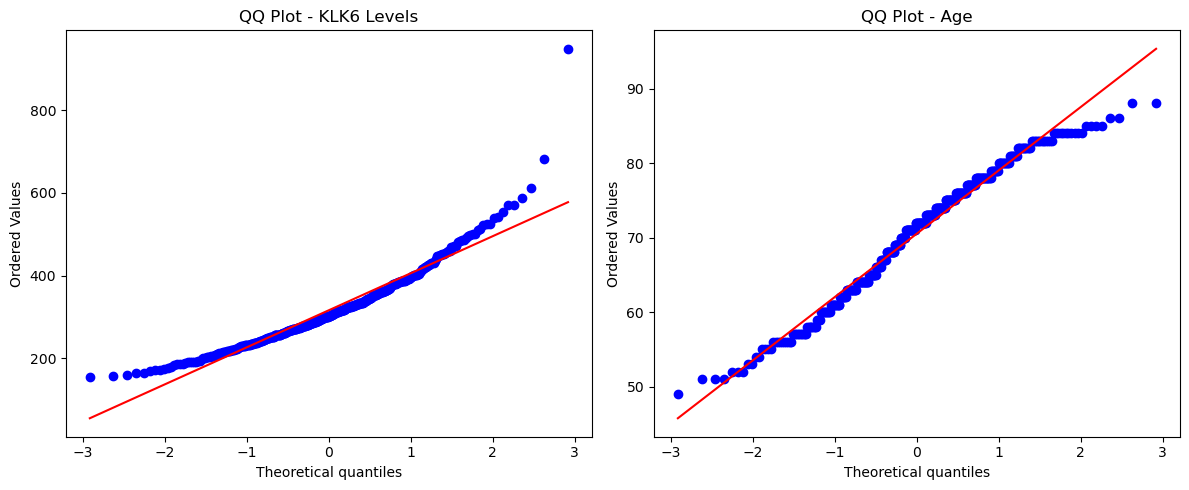

In [ ]:
#Correlation with age

print("=" *50)
print("CORRELATION WITH AGE")
print("="*50)

# Check normality using QQ plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
stats.probplot(df['Value'].dropna(), dist="norm", plot=ax1)
ax1.set_title('QQ Plot - KLK6 Levels') #all diagnoses combined
stats.probplot(df['Age'].dropna(), dist="norm", plot=ax2)
ax2.set_title('QQ Plot - Age')
plt.tight_layout()
plt.show()

In [150]:
# Perform Spearman correlation (non-parametric, more robust)
spearman_corr_age, spearman_p_age = stats.spearmanr(df['Value'].dropna(), df['Age'].dropna())
print(f"Spearman Correlation: ρ = {spearman_corr_age:.3f}, p = {spearman_p_age:.4f}")

Spearman Correlation: ρ = 0.240, p = 0.0000


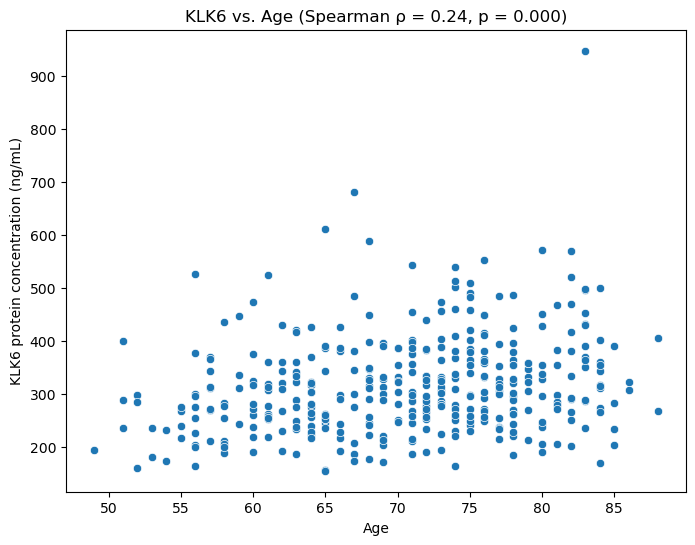

In [151]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Age', y='Value')
plt.title(f'KLK6 vs. Age (Spearman ρ = {spearman_corr_age:.2f}, p = {spearman_p_age:.3f})')
plt.xlabel("Age")
plt.ylabel("KLK6 protein concentration (ng/mL)")
plt.show()

In [152]:
#Correlation with Sex
print('='*50)
print('CORRELATION WITH SEX')
print('='*50)

# Check normality within each group using Shapiro-Wilk
for sex_group in df['Sexo'].unique():
    group_data = df[df['Sexo'] == sex_group]['Value'].dropna()
    stat, p = stats.shapiro(group_data)
    print(f"Shapiro-Wilk for {sex_group}: p = {p:.4f}")

#Use Mann-Whitney U test, non-normal data
male_data = df[df['Sexo']== 'Male']['Value'].dropna()
female_data = df[df['Sexo']== 'Female']['Value'].dropna()

stat_sex, p_value_sex = stats.mannwhitneyu(male_data, female_data, alternative= 'two-sided')
print(f"\nMann-Whitney U Test: U = {stat_sex}, p = {p_value_sex:.4f}")

CORRELATION WITH SEX
Shapiro-Wilk for Male: p = 0.0000
Shapiro-Wilk for Female: p = 0.0000

Mann-Whitney U Test: U = 21091.5, p = 0.1055


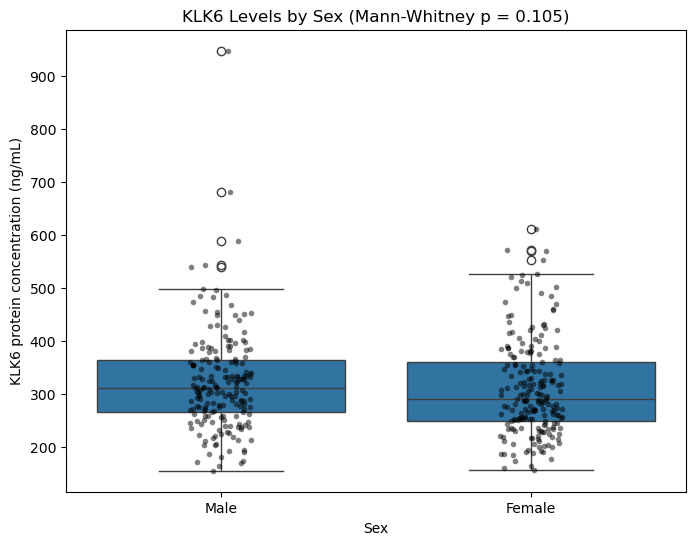

In [153]:
# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Sexo', y='Value')
sns.stripplot(data=df, x='Sexo', y='Value', color='black', alpha=0.5, size=4)
plt.xlabel("Sex")
plt.ylabel("KLK6 protein concentration (ng/mL)")
plt.title(f'KLK6 Levels by Sex (Mann-Whitney p = {p_value_sex:.3f})')
plt.show()

In [165]:
#Correlation with MMSE score

print('='*50)
print("CORELATION WITH MMSE SCORE")
print('='*50)

#Because we know there are NAs here, we create a temporary dataframe to avoid errors
mmse_temp_df = df[["Value", 'MMSE_PL']].dropna()
print(f"Original sample size: {len(df)}")
print(f"Sample size after removing missing values: {len(mmse_temp_df)}")

# Perform Spearman correlation
spearman_corr_mmse, spearman_p_mmse = stats.spearmanr(mmse_temp_df['Value'].dropna(), mmse_temp_df['MMSE_PL'].dropna())
print(f"Spearman Correlation: ρ = {spearman_corr_mmse:.3f}, p = {spearman_p_mmse:.4f}")

CORELATION WITH MMSE SCORE
Original sample size: 393
Sample size after removing missing values: 375
Spearman Correlation: ρ = -0.164, p = 0.0014


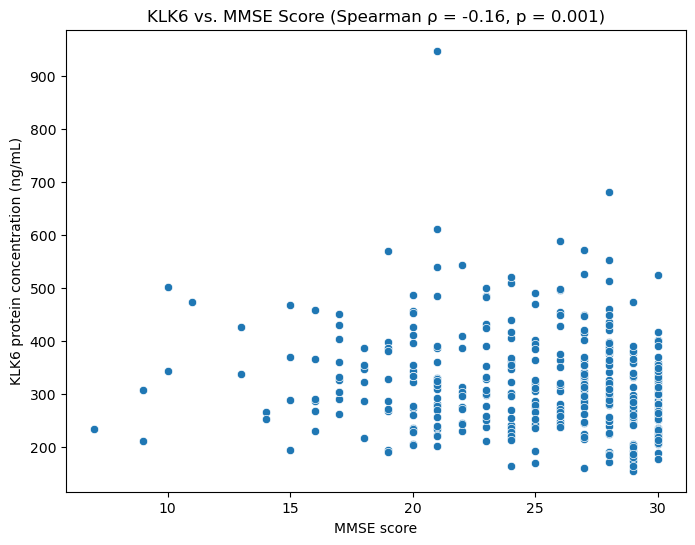

In [155]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=mmse_temp_df, x='MMSE_PL', y='Value')
plt.title(f'KLK6 vs. MMSE Score (Spearman ρ = {spearman_corr_mmse:.2f}, p = {spearman_p_mmse:.3f})')
plt.xlabel("MMSE score")
plt.ylabel("KLK6 protein concentration (ng/mL)")
plt.show()

In [162]:
#Correlation with APOE status

print('='*50)
print("CORRELATION WITH APOE STATUS")
print('='*50)

#remove NAs like in the MMSE analysis
apoe_temp_df = df[["log2_Value","Value", 'APOE']].dropna()

# Prepare data for ANOVA - create a list of arrays for each group
apoe_groups = []
for status in apoe_temp_df['APOE'].unique():
    group_data = apoe_temp_df[apoe_temp_df['APOE'] == status]['log2_Value']
    apoe_groups.append(group_data)
    print(f"APOE {status}: n = {len(group_data)}, mean = {np.mean(group_data):.2f} ± {np.std(group_data):.2f}")

# Perform one-way ANOVA
f_stat_apoe, p_value_apoe = f_oneway(*apoe_groups)
print(f"\nOne-way ANOVA: F = {f_stat_apoe:.3f}, p = {p_value_apoe:.4f}")

# If ANOVA is significant (p < 0.05), perform Tukey's HSD post-hoc test
if p_value < 0.05:
    print("\nPerforming Tukey's HSD post-hoc test:")
    # Prepare data for Tukey test
    tukey_data = apoe_temp_df[['log2_Value', 'APOE']].dropna()
    tukey_results = pairwise_tukeyhsd(tukey_data['log2_Value'], tukey_data['APOE'])
    print(tukey_results)
    
    # Plot the results
    tukey_results.plot_simultaneous()
    plt.title("Tukey HSD Post-hoc Test - Confidence Intervals")
    plt.show()
else:
    print("ANOVA not significant - no post-hoc tests needed.")


CORRELATION WITH APOE STATUS
APOE e2e3: n = 33, mean = 8.27 ± 0.33
APOE e3e3: n = 206, mean = 8.22 ± 0.41
APOE e3e4: n = 116, mean = 8.34 ± 0.39
APOE e4e4: n = 20, mean = 8.13 ± 0.28
APOE e2e4: n = 7, mean = 8.19 ± 0.48

One-way ANOVA: F = 2.215, p = 0.0668
ANOVA not significant - no post-hoc tests needed.


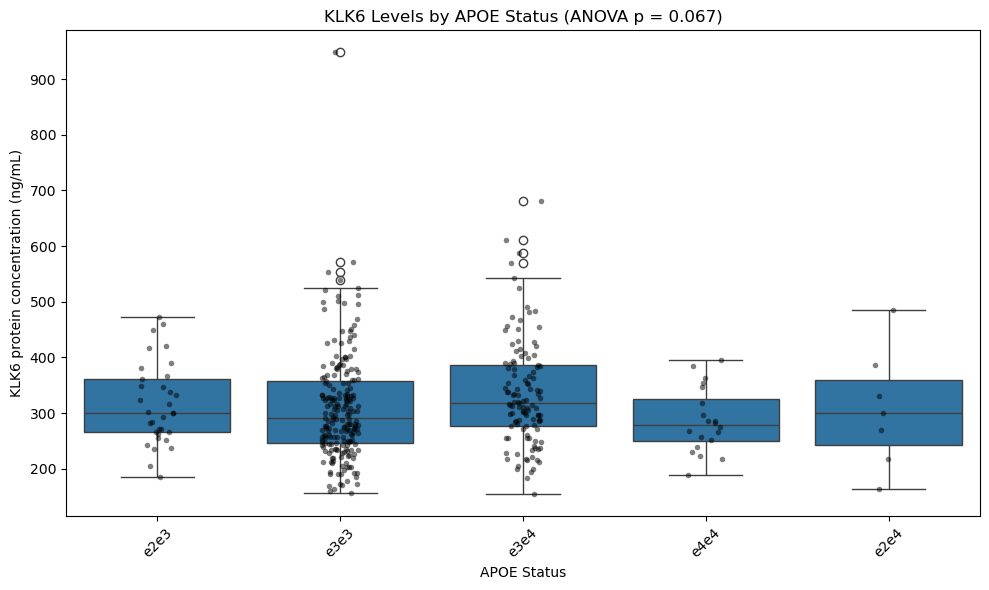

In [163]:
# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=apoe_temp_df, x='APOE', y='Value')
sns.stripplot(data=apoe_temp_df, x='APOE', y='Value', color='black', alpha=0.5, size=4)
plt.title(f'KLK6 Levels by APOE Status (ANOVA p = {p_value_apoe:.3f})')
plt.xticks(rotation=45)
plt.xlabel("APOE Status")
plt.ylabel("KLK6 protein concentration (ng/mL)")
plt.tight_layout()
plt.show()

In [164]:
#IMPORTANT

#Correct for multiple testing

print('='*50)
print('MULTIPLE TESTING CORRECTION')
print('='*50)

raw_p_values = [spearman_p_age, p_value_sex, spearman_p_mmse, p_value_apoe]  # [Age, Sex, MMSE, APOE]

# Apply Bonferroni correction manually
bonferroni_p = [p * len(raw_p_values) for p in raw_p_values]
bonferroni_p = [min(p, 1.0) for p in bonferroni_p]  # Cap at 1.0

# Create a summary DataFrame
variables = ['Age', 'Sex', 'MMSE', 'APOE_Status']
tests = ['Spearman', 'Mann-Whitney U', 'Spearman', 'ANOVA']

results_summary = pd.DataFrame({
    'Variable': variables,
    'Test': tests,
    'Raw_p_value': raw_p_values,
    'Bonferroni_p': bonferroni_p
})

print("Summary of Results with Multiple Testing Correction:")
print(results_summary.round(4))

# Highlight significant results after correction
print("\nSignificant results after Bonferroni correction (p < 0.05):")
significant_results = results_summary[results_summary['Bonferroni_p'] < 0.05]
if len(significant_results) > 0:
    print(significant_results[['Variable', 'Bonferroni_p']])
else:
    print("No significant results after multiple testing correction.")

MULTIPLE TESTING CORRECTION
Summary of Results with Multiple Testing Correction:
      Variable            Test  Raw_p_value  Bonferroni_p
0          Age        Spearman       0.0000        0.0000
1          Sex  Mann-Whitney U       0.1055        0.4219
2         MMSE        Spearman       0.0014        0.0057
3  APOE_Status           ANOVA       0.0668        0.2673

Significant results after Bonferroni correction (p < 0.05):
  Variable  Bonferroni_p
0      Age      0.000006
2     MMSE      0.005708


## Create plots with raw data

C:\Users\miyoh\AppData\Local\Temp\ipykernel_11044\1589949917.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(y = "Value", x= "Group",palette= "RdBu", data= df)


Text(0.5, 1.0, 'Comparison of KLK6 in the AD continuum')

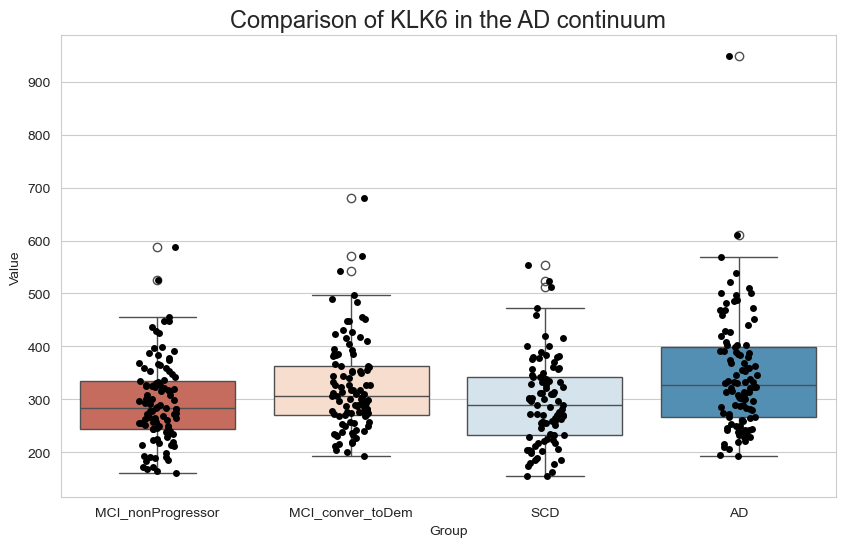

In [20]:
#Scatterplot with boxplot

plt.figure(figsize=(10,6))

# Set the style to include a grid
sns.set_style("whitegrid")

ax1 = sns.boxplot(y = "Value", x= "Group",palette= "RdBu", data= df)
sns.stripplot(y = "Value", x="Group", ax= ax1, data= df, color = "black")



plt.title("Comparison of KLK6 in the AD continuum", fontsize = 17)

C:\Users\miyoh\AppData\Local\Temp\ipykernel_11044\1499302018.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y = df["Value"], x= df["Group"], palette= "RdBu")


Text(0.5, 1.0, 'Comparison of KLK6 in the AD continuum')

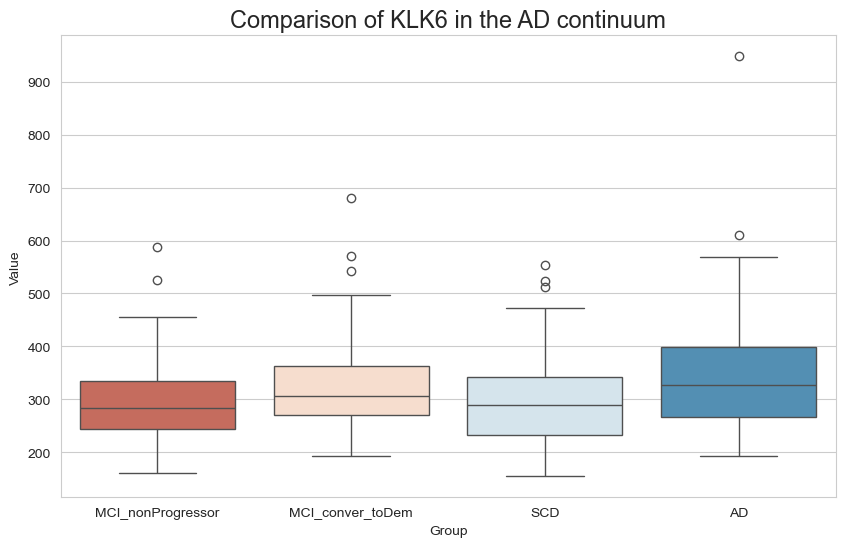

In [22]:
#Boxplot
plt.figure(figsize=(10,6))
ax = sns.boxplot(y = df["Value"], x= df["Group"], palette= "RdBu")

# Set the style to include a grid
sns.set_style("whitegrid")


plt.title("Comparison of KLK6 in the AD continuum", fontsize = 17)


## Create Plots with Log2 data

(7.105036179299593, 11.0)

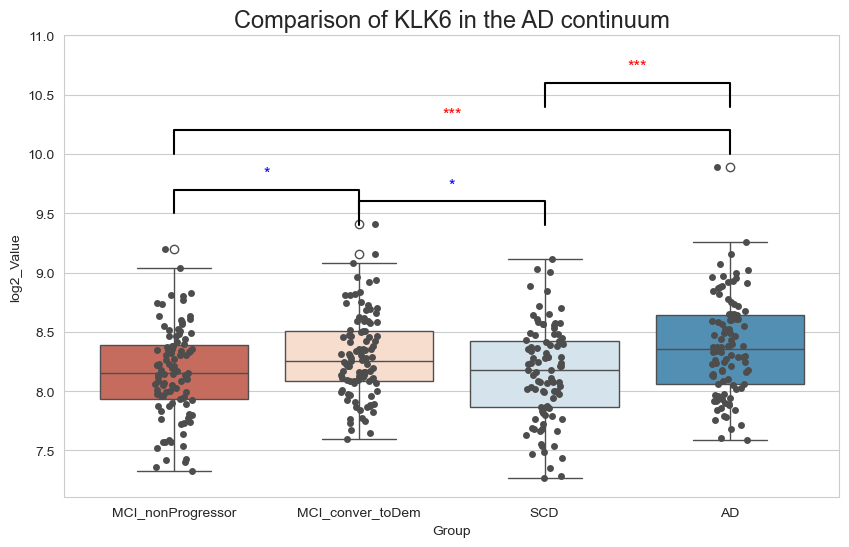

In [23]:
#Scatterplot with boxplot

plt.figure(figsize=(10,6))

# Set the style to include a grid
sns.set_style("whitegrid")

ax1 = sns.boxplot(y = df["log2_Value"], x= df["Group"], hue= "Group",palette= "RdBu", data= df)
sns.stripplot(y = df["log2_Value"], x= df["Group"], ax= ax1, data= df, color = ".3")

#manually check the sig p values
add_sig_bars(ax1, "MCI_nonProgessor", "MCI_conver_toDem",p_values[3],0 ,1, 9.5)
add_sig_bars(ax1, "AD", "MCI_nonProgessor",p_values[1],0 ,3, 10)
add_sig_bars(ax1, "AD", "SCD",p_values[2],2 ,3, 10.4)
add_sig_bars(ax1, "SCD", "MCI_conver_toDem",p_values[4],1 ,2, 9.4)


plt.title("Comparison of KLK6 in the AD continuum", fontsize = 17)
plt.ylim(top=11.0)

In [ ]:
#Boxplot
plt.figure(figsize=(10,6))
ax = sns.boxplot(y = df["log2_Value"], x= df["Group"], palette= "RdBu")

# Set the style to include a grid
sns.set_style("whitegrid")

#manually check the sig p values
add_sig_bars(ax, "MCI_nonProgessor", "MCI_conver_toDem",p_values[3],0 ,1, 9.5)
add_sig_bars(ax, "AD", "MCI_nonProgessor",p_values[1],0 ,3, 10)
add_sig_bars(ax, "AD", "SCD",p_values[2],2 ,3, 10.4)
add_sig_bars(ax, "SCD", "MCI_conver_toDem",p_values[4],1 ,2, 9.4)


plt.title("Comparison of KLK6 in the AD continuum", fontsize = 17)
plt.ylim(top=11.0)

## In this section we create tables for patient statistics

In [ ]:
#define for InterQuartile Range
def calculate_iqr(dataframe):
    q1 = dataframe.quantile(0.25)
    q3 = dataframe.quantile(0.75)
    return q3 - q1

def q1(dataframe):
    return dataframe.quantile(0.25)

def q3(dataframe):
    return dataframe.quantile(0.75)


In [ ]:
#Interquartile range
iqr = df.groupby("Group")["Value"].apply(calculate_iqr)
print(iqr)

print("-"*30)
iqr_log2 = df.groupby("Group")["log2_Value"].apply(calculate_iqr)
print(iqr_log2)


In [ ]:
#Find the Q1 and Q3 by applying the functions
q_25 = df.groupby("Group")["Value"].apply(q1) #25th quantile
print(q_25)

print("-"*30)
q_75 = df.groupby("Group")['Value'].apply(q3) #75th quantile
print(q_75)

print("-"*30)
q_25_log = df.groupby("Group")["log2_Value"].apply(q1)
print(q_25_log)

print("-"*30)
q_75_log = df.groupby("Group")['log2_Value'].apply(q3)
print(q_75_log)

In [ ]:
# Group by 'Group' and apply multiple aggregation functions to 'Value' and 'log2_Value
# Save the tables to an Excel file
table1_values = df.groupby('Group').agg({'Value': ['mean', 'median', 'std', 'min', 'max']})
Table1 = pd.concat([table1_values,q_25, q_75], join= "inner", axis=1) #concat to add quartiles
Table1.columns = ["Mean", "Median", "std", "Min", "Max", "Q1", "Q3"]#add headers to q_25 and q_75
print(Table1)
Table1.to_excel("my_table_values.xlsx")

table1_values_log2 = df.groupby('Group').agg({'log2_Value': ['mean', 'median', 'std', 'min', 'max']})
Table1_log2 = pd.concat([table1_values_log2,q_25_log, q_75_log], join= "inner", axis=1) #concat
Table1_log2.columns = ["Mean", "Median", "std", "Min", "Max", "Q1", "Q3"]#add headers to q_25 and q_75
print(Table1_log2)
Table1_log2.to_excel("my_table_log2_values.xlsx")